# Binary Classifier on Particle Track Data

In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys
import numpy as np
import math

## Get angle values and cast to boolean

In [3]:
track_params = pd.read_csv('../TRAIN/track_parms.csv')

In [4]:
track_params.tail()

,filename,phi,z,phi_calc,phi_regression,sigma_regression
499995,img499995.png,-4.509653,0.968584,-4.494071,-4.494040,0.014105
499996,img499996.png,-1.595661,-7.397094,-1.645501,-1.645483,0.014181
499997,img499997.png,7.695264,-2.984060,7.799254,7.799186,0.013931
499998,img499998.png,-1.898667,5.082713,-1.880849,-1.880834,0.014177
499999,img499999.png,4.275843,-2.266920,4.324348,4.324317,0.014112


## Create our simple classification target

In [5]:
# Create binary labels
track_params['phi_bool'] = track_params.phi.apply(lambda x: "+" if x > 0 else "-")

## Look at the distributions to see if we have any imbalances

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x104512128>,
      dtype=object)

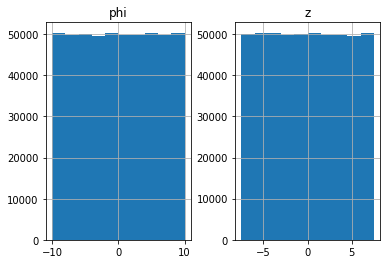

In [6]:
track_params[['phi', 'z']].hist()

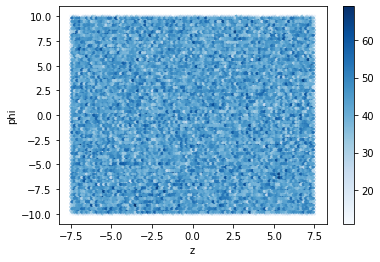

In [7]:
track_params.plot(x='z', y='phi', kind='hexbin', sharex=False, cmap="Blues")

* looks like a perfectly balanced dataset to me, so we don't have to worry about the type of complications that arise from am imbalanced set.

In [8]:
track_params.head()

,filename,phi,z,phi_calc,phi_regression,sigma_regression,phi_bool
0,img000000.png,-0.195900,-5.164839,-0.206930,-0.206928,0.014192,-
1,img000001.png,-1.473349,5.784543,-1.409622,-1.409614,0.014184,-
2,img000002.png,9.206585,-2.295192,9.296442,9.296330,0.016293,+
3,img000003.png,5.378890,4.685070,5.281532,5.281474,0.014072,+
4,img000004.png,-6.700401,-0.851756,-6.739551,-6.739504,0.013997,-


## Create an image generator from this dataframe

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [11]:
DATAGEN = ImageDataGenerator(rescale=1./255.,
                             validation_split=0.25)

In [12]:
height = 100
width = 36

def create_generator(target, subset, class_mode,
                     idg=DATAGEN, df=track_params, N=1000):
    
    return idg.flow_from_dataframe(
        dataframe=track_params.head(N),
        directory="../TRAIN",
        x_col="filename",
        y_col=target,
        subset=subset,
        target_size=(height, width),
        batch_size=32,
        seed=314,
        shuffle=True,
        class_mode=class_mode,
    )

In [13]:
binary_train_generator = create_generator(
    target="phi_bool",
    subset="training",
    class_mode="binary"
)
binary_val_generator = create_generator(
    target="phi_bool",
    subset="validation",
    class_mode="binary"
)

Found 750 validated image filenames belonging to 2 classes.
Found 250 validated image filenames belonging to 2 classes.


## Create a very simple convolutional model from scratch

In [14]:
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import (
    Conv2D, Activation, MaxPooling2D,
    Flatten, Dense, Dropout, Input
)

### Model Definition

In [15]:
width  = 36
height = 100
channels = 3

def binary_classifier():
    model = Sequential()

    # Convolutional Block Layer
    model.add(Conv2D(32, (3, 3), input_shape=(height, width, channels)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Dense, Classification Layer
    model.add(Flatten())
    model.add(Dense(32))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    
    return model

## Train this model

In [16]:
STEP_SIZE_TRAIN = binary_train_generator.n//binary_train_generator.batch_size
STEP_SIZE_VAL = binary_val_generator.n//binary_val_generator.batch_size

In [17]:
binary_model = binary_classifier()
binary_history = binary_model.fit_generator(
    generator=binary_train_generator,
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_data=binary_val_generator,
    validation_steps=STEP_SIZE_VAL,
    epochs=5
)

W0815 06:45:40.222872 4567270848 deprecation.py:323] From /Users/dannowitz/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/5
23/23 [==============================] - 2s 77ms/step - loss: 0.1190 - accuracy: 0.9777 - val_loss: 9.2283e-05 - val_accuracy: 1.0000
Epoch 2/5
23/23 [==============================] - 1s 30ms/step - loss: 6.3248e-04 - accuracy: 1.0000 - val_loss: 2.6192e-05 - val_accuracy: 1.0000
Epoch 3/5
23/23 [==============================] - 1s 31ms/step - loss: 8.2586e-04 - accuracy: 1.0000 - val_loss: 1.3146e-05 - val_accuracy: 1.0000
Epoch 4/5
23/23 [==============================] - 1s 31ms/step - loss: 8.7263e-04 - accuracy: 1.0000 - val_loss: 3.5262e-06 - val_accuracy: 1.0000
Epoch 5/5
23/23 [==============================] - 1s 30ms/step - loss: 2.1041e-04 - accuracy: 1.0000 - val_loss: 2.1267e-06 - val_accuracy: 1.0000


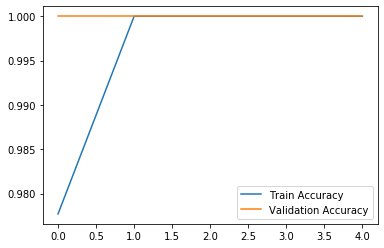

In [19]:
plt.plot(binary_history.history['accuracy'], label="Train Accuracy")
plt.plot(binary_history.history['val_accuracy'], label="Validation Accuracy")
plt.legend()
plt.show()

## Okay, maybe that was too easy

* I mean, if any pixels are lit up on the top half / bottom half, it's a smoking gun.
* Let's make it harder with binned measurements and treat it as categorical.